## Churn Prediction using AMLWorkbench

This notebook will introduce the use of the churn dataset to create churn prediction models. The dataset used to ingest is from SIDKDD 2009 competition. The dataset consists of heterogeneous noisy data (numerical/categorical variables) from French Telecom company Orange and is anonymized.

We will use the .dprep file created from the datasource wizard.

In [1]:
import dataprep
from dataprep.Package import Package
import pickle

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import numpy as np
import csv
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder

C:\Users\mikher\AppData\local\AmlWorkbench\Python\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read Data

We first retrieve the data as a data frame using .dprep that we created using the datasource wizard. Print the top few lines using head()

In [2]:
#Local via package
with Package.open_package('CATelcoCustomerChurnTrainingSample.dprep') as pkg:
    df = pkg.dataflows[0].get_dataframe()

# Blob via package
#with Package.open_package('CATelcoCustomerChurnTrainingBlobSample.dprep') as pkg:
#    df = pkg.dataflows[0].get_dataframe()
    
# if this one fails check to see that you are NOT exporting file to local/blob
# storage because it will fail to overwrite

# Local via CSV file
# df = pd.read_csv("./data/CATelcoCustomerChurnTrainingSample.csv")
# df = pd.read_csv("./data/CATelcoCustomerChurnTrainingCleaned.csv")

df.head(5)

,age,age_bin,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,...,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn
0,12.0,0-19,168147.0,0.06,0.00,4.251078e+09,1.0,Yes,Bachelor or equivalent,Male,...,371.0,WA,15.0,19.0,No,No,0.82,5971.0,663.0,0.0
1,12.0,0-19,168147.0,0.06,0.00,4.251078e+09,1.0,Yes,Bachelor or equivalent,Male,...,371.0,WA,15.0,19.0,No,No,0.82,3981.0,995.0,0.0
2,42.0,40-59,29047.0,0.05,0.01,4.251043e+09,2.0,Yes,Bachelor or equivalent,Female,...,43.0,WI,212.0,34.0,No,Yes,0.27,7379.0,737.0,0.0
3,42.0,40-59,29047.0,0.05,0.01,4.251043e+09,2.0,Yes,Bachelor or equivalent,Female,...,43.0,WI,212.0,34.0,No,Yes,0.27,1729.0,432.0,0.0
4,58.0,40-59,27076.0,0.07,0.02,4.251056e+09,3.0,Yes,Master or equivalent,Female,...,403.0,KS,216.0,144.0,No,No,0.48,3122.0,624.0,0.0


In [29]:
df.shape

(20468, 28)

In [3]:
# What is the index for the churn column
df.columns.get_loc("churn")

27

## Encode Columns

Convert categorical variable into dummy/indicator variables using pandas.get_dummies. In addition, we will need to change the column names to ensure there are no multiple columns with the same name 

In [4]:
# Pick columns of the type category (object represents strings)
columns_to_encode = list(df.select_dtypes(include=['category','object']))
print(columns_to_encode)
# Create new columns for each value in the chosen columns. Use the the indicator value 1 for a value set. 
for column_to_encode in columns_to_encode:
    # Create a new column for each unique value a column has
    # The value becomes a column name
    # See: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
    dummies = pd.get_dummies(df[column_to_encode])
    # Save column names in this variable
    one_hot_col_names = []
    for col_name in list(dummies.columns):
        # Use the original column name followed by the value of the category
        one_hot_col_names.append(column_to_encode + '_' + col_name)
    # Assign new column names
    dummies.columns = one_hot_col_names
    # drop the original columns that are now one-hot-encoded (axis=1 means to drop columns)
    df = df.drop(column_to_encode, axis=1)
    # merge the original data frame with the newly constructed columns
    df = df.join(dummies)

print("Encoded columns:")
print(df.columns)

['age_bin', 'customersuspended', 'education', 'gender', 'homeowner', 'maritalstatus', 'noadditionallines', 'occupation', 'state', 'usesinternetservice', 'usesvoiceservice']
Encoded columns:
Index(['age', 'annualincome', 'calldroprate', 'callfailurerate', 'callingnum',
       'customerid', 'monthlybilledamount', 'numberofcomplaints',
       'numberofmonthunpaid', 'numdayscontractequipmentplanexpiring',
       'penaltytoswitch', 'totalminsusedinlastmonth', 'unpaidbalance',
       'percentagecalloutsidenetwork', 'totalcallduration', 'avgcallduration',
       'churn', 'age_bin_0-19', 'age_bin_0-39', 'age_bin_20-39',
       'age_bin_20-59', 'age_bin_40-59', 'age_bin_40-79', 'age_bin_60-79',
       'age_bin_60-99', 'customersuspended_No', 'customersuspended_Yes',
       'education_Bachelor or equivalent', 'education_High School or below',
       'education_Master or equivalent', 'education_PhD or equivalent',
       'gender_Female', 'gender_Male', 'homeowner_No', 'homeowner_Yes',
       'mar

In [5]:
# Lets look at our newly created columns (one-hot-encoded)
df

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,usesinternetservice_No,usesinternetservice_Yes,usesvoiceservice_No,usesvoiceservice_Yes
0,12.0,168147.0,0.06,0.00,4.251078e+09,1.0,71.0,0.0,7.0,96.0,...,0,0,1,0,0,0,1,0,1,0
1,12.0,168147.0,0.06,0.00,4.251078e+09,1.0,71.0,0.0,7.0,96.0,...,0,0,1,0,0,0,1,0,1,0
2,42.0,29047.0,0.05,0.01,4.251043e+09,2.0,8.0,1.0,4.0,14.0,...,0,0,0,1,0,0,1,0,0,1
3,42.0,29047.0,0.05,0.01,4.251043e+09,2.0,8.0,1.0,4.0,14.0,...,0,0,0,1,0,0,1,0,0,1
4,58.0,27076.0,0.07,0.02,4.251056e+09,3.0,16.0,0.0,2.0,55.0,...,0,0,0,0,0,0,1,0,1,0
5,58.0,27076.0,0.07,0.02,4.251056e+09,3.0,16.0,0.0,2.0,55.0,...,0,0,0,0,0,0,1,0,1,0
6,20.0,137977.0,0.05,0.03,4.251042e+09,4.0,74.0,1.0,7.0,73.0,...,0,0,0,0,0,0,0,1,1,0
7,20.0,137977.0,0.05,0.03,4.251042e+09,4.0,74.0,1.0,7.0,73.0,...,0,0,0,0,0,0,0,1,1,0
8,36.0,136006.0,0.07,0.00,4.251073e+09,5.0,81.0,0.0,5.0,14.0,...,0,0,0,0,0,0,1,0,1,0
9,36.0,136006.0,0.07,0.00,4.251073e+09,5.0,81.0,0.0,5.0,14.0,...,0,0,0,0,0,0,1,0,1,0


## Modeling

First, we will build a Gaussian Naive Bayes model using GaussianNB for churn classification. Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes theorem with the “naive” assumption of independence between every pair of features.

In addition, we will also build a decision tree classifier for comparison:

- min_samples_split=20 requires 20 samples in a node for it to be split
- random_state=99 to seed the random number generator

## Investigate important features
Not all features might be important. Try to find the features that influence the most bu using the TreeClassifier.

In [6]:
from sklearn.ensemble import ExtraTreesClassifier

train, test = train_test_split(df, test_size = 0.3)
Y = train['churn'].values
X = train.drop('churn', 1)
X = X.values

model_feature_test = ExtraTreesClassifier()
model_feature_test.fit(X, Y)
features_ranked = model_feature_test.feature_importances_
print("Feature importance (the number indicates the importance of each column in the data frame:\n" + str(features_ranked))

# Pick the index for the top ranked features (20)
ind = np.argpartition(features_ranked, -20)[-20:]
print("Top Feature Index:\n" + str(ind))
print("Top feature values\n")
print(features_ranked[ind])
top_feature_names = train.columns[ind]
print("Top feature names:\n" + str(top_feature_names))

Feature importance (the number indicates the importance of each column in the data frame:
[ 0.03645095  0.03841725  0.03247994  0.02763392  0.03520999  0.03539594
  0.03612279  0.03228078  0.03337635  0.0341161   0.03227962  0.03687099
  0.04083459  0.03501806  0.01629636  0.01769744  0.00572517  0.00253198
  0.01144765  0.0042155   0.00962697  0.00092558  0.00598868  0.00093692
  0.00367671  0.00377824  0.01684808  0.01644178  0.00871443  0.00764337
  0.01448051  0.01519122  0.01125589  0.01158391  0.00951967  0.00912176
  0.          0.01557804  0.01591472  0.01532977  0.00485963  0.00171976
  0.00602957  0.00679704  0.00655078  0.00556578  0.00332974  0.00423485
  0.00416489  0.00399134  0.00514014  0.00679601  0.0038843   0.00275904
  0.00410852  0.00590701  0.00464576  0.00288357  0.0048132   0.00376264
  0.00572613  0.00504556  0.00403726  0.00442494  0.00375068  0.00599556
  0.0056977   0.00679187  0.00337416  0.00523362  0.00393356  0.00378165
  0.00385441  0.00543197  0.004110

In [7]:
# Index of the churn column
df.columns.get_loc("churn")

16

In [8]:
# Number of columns we now have
len(df.columns)

95

## Train on only top features

In [9]:
top_feature_names

Index(['noadditionallines_\N', 'occupation_Non-technology Related Job',
       'education_Bachelor or equivalent', 'totalcallduration',
       'customersuspended_Yes', 'avgcallduration', 'annualincome',
       'percentagecalloutsidenetwork', 'unpaidbalance',
       'totalminsusedinlastmonth', 'penaltytoswitch',
       'numdayscontractequipmentplanexpiring', 'numberofmonthunpaid',
       'numberofcomplaints', 'monthlybilledamount', 'customerid', 'callingnum',
       'callfailurerate', 'calldroprate', 'age'],
      dtype='object')

#### Decision tree classifier

In [10]:
model = DecisionTreeClassifier(max_depth=20, max_features=20, random_state=98)

# top_feature_names.append(['churn'])
dfChurn = df[['churn']]
dfFeatures = df[top_feature_names]
dfTopFeaturesChurn = dfFeatures.join(dfChurn)

train, test = train_test_split(df, test_size = 0.3, random_state=98)
# Does top features only improve the classifier?
# train, test = train_test_split(dfTopFeaturesChurn, test_size = 0.3, random_state=98)
target = train['churn'].values
train = train.drop('churn', 1)
train = train.values
model.fit(train, target)

Y_test_val = test['churn'].values
X_test_val = test.drop('churn', 1).values
predicted = model.predict(X_test_val)
print("Decision Tree Classification Accuracy", accuracy_score(Y_test_val, predicted))


Decision Tree Classification Accuracy 0.92102263475


In [11]:
print("#Expected churn: " + str(sum(Y_test_val[Y_test_val[:] > 0])))
print("#Predcited churn: " + str(sum(predicted[predicted[:] > 0])))

#Expected churn: 573.0
#Predcited churn: 432.0


In [12]:
# Calculate confusion matrix
exp_inp = pd.Categorical(Y_test_val, categories=[0,1])
pred_inp = pd.Categorical(predicted, categories=[0,1])
print(pd.crosstab(exp_inp, pred_inp, colnames=["Predicted"], rownames=['Actual']))

Predicted     0    1
Actual              
0          5396  172
1           313  260


|Predicted|     0 |  1 |
|---------|-------|----|
|Actual   |       |    |             
|0        |   2665|  49|
|1        |    282|   4|

Accuracy example: acc = correct predicted / all predictions<br>
(2665 + 4)/ (2665 + 49 + 282 + 4) = 0.8897

#### ROC curve

AUC:0.819863192313


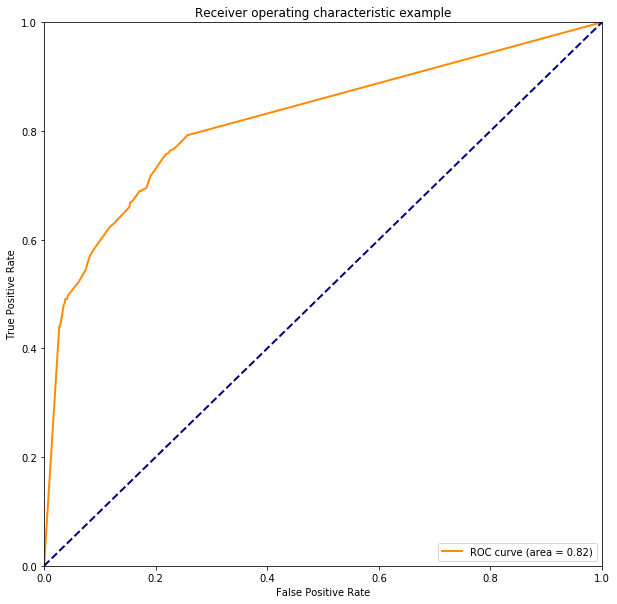

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
predicted_prob = model.predict_proba(X_test_val)
# TASK: Rita ROC curve
# confidence_nb = predicted_prob.max(axis=1)
fpr, tpr, thresholds = roc_curve(Y_test_val, predicted_prob[:, 1])
roc_auc_nb = roc_auc_score(Y_test_val, predicted_prob[:, 1])
print("AUC:" + str(roc_auc_nb))

plt.figure(figsize=(10,10))
plt.title('Receiver operating characteristic example')
plt.plot(fpr, tpr, color='darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Precision and recall
High recall means that we manage to pick most of the positive examples (churn)
Low precision means that we also pick a lot of false positive for the churn which
means that a high recall and a low precision catches most of the true churn at the
cost of getting many false churn at the same time. Low precision = not so precise

See: https://medium.com/@klintcho/explaining-precision-and-recall-c770eb9c69e9 for a good explanation.

The chart below calculates the precision and recall for the different thresholds of the probability of our predicions.

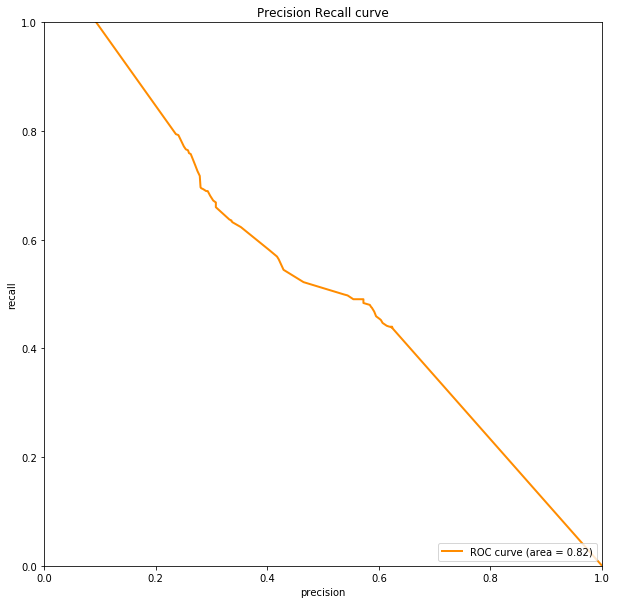

Precision:
[ 0.0933  0.2362  0.2407  0.2506  0.2541  0.258   0.2597  0.2629  0.267
  0.271   0.275   0.279   0.2804  0.2817  0.2852  0.2904  0.2932  0.2977
  0.3031  0.3079  0.3078  0.3321  0.3358  0.3361  0.338   0.3528  0.4031
  0.4174  0.4206  0.4292  0.465   0.5376  0.5439  0.5542  0.5723  0.5723
  0.5839  0.5858  0.5875  0.5916  0.595   0.6019  0.6037  0.6066  0.6141
  0.6192  0.6222  0.6238  0.6228  0.6244  0.625   1.    ]
Recall:
[ 1.      0.7941  0.7923  0.7714  0.7661  0.7644  0.7592  0.7574  0.7469
  0.7365  0.726   0.7173  0.6963  0.6946  0.6928  0.6894  0.6894  0.6806
  0.6719  0.6684  0.6597  0.637   0.6353  0.6335  0.6318  0.623   0.5812
  0.5689  0.5637  0.5445  0.5218  0.4991  0.4974  0.4904  0.4904  0.4834
  0.4799  0.4764  0.4747  0.4677  0.459   0.4538  0.452   0.4468  0.4415
  0.4398  0.4398  0.4398  0.438   0.438   0.4363  0.    ]


In [14]:
precision, recall, thresholds_pr = precision_recall_curve(Y_test_val, predicted_prob[:,1])
plt.figure(figsize=(10,10))
plt.title('Precision Recall curve')
plt.plot(precision, recall, color='darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('precision')
plt.ylabel('recall')
plt.show()
print("Precision:\n" + str(precision.round(4)))
print("Recall:\n" + str(recall.round(4)))

#print("\nIf we want to catch every churn the precision would be only " + "{:.2%}".format(precision[0]))
#print("I.e. we would catch a huge number of false positive at the same time.")
#print("The other way around. If we want only True positive churn (no false) we would get a recall of " + "{:.2%}".format(recall[6]))

### ExtraTrees Classifier

In [42]:
help(ExtraTreesClassifier)

Help on class ExtraTreesClassifier in module sklearn.ensemble.forest:

class ExtraTreesClassifier(ForestClassifier)
 |  An extra-trees classifier.
 |  
 |  This class implements a meta estimator that fits a number of
 |  randomized decision trees (a.k.a. extra-trees) on various sub-samples
 |  of the dataset and use averaging to improve the predictive accuracy
 |  and control over-fitting.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  max_features : int, float, string or None, optional (default="auto")
 |      The number of features to consider when looking for the best split:
 |  
 |      - If int, then consider `max_features` features

In [15]:
modelxt = ExtraTreesClassifier(max_depth=25, n_estimators=15, max_features=20, random_state=99)
# modelxt = RandomForestClassifier()

# top_feature_names.append(['churn'])
dfChurn = df[['churn']]
dfFeatures = df[top_feature_names]
dfTopFeaturesChurn = dfFeatures.join(dfChurn)

train, test = train_test_split(dfTopFeaturesChurn, test_size = 0.3, random_state=98)

target = train['churn'].values
train = train.drop('churn', 1)
train = train.values
modelxt.fit(train, target)

Y_test_val = test['churn'].values
X_test_val = test.drop('churn', 1).values
predicted = modelxt.predict(X_test_val)
print("ExtraTreesClassifier acc:", accuracy_score(Y_test_val, predicted))

ExtraTreesClassifier acc: 0.976062530532


#### Confusion matrix

In [16]:
print("#Actual churn: " + str(sum(Y_test_val[Y_test_val[:] > 0])))
print("#Predcited churn: " + str(sum(predicted[predicted[:] > 0])))

#Actual churn: 573.0
#Predcited churn: 444.0


In [17]:
exp_inp = pd.Categorical(Y_test_val, categories=[0,1])
pred_inp = pd.Categorical(predicted, categories=[0,1])
print(pd.crosstab(exp_inp, pred_inp, colnames=["Predicted"], rownames=['Actual']))

Predicted     0    1
Actual              
0          5559    9
1           138  435


####  Confusion matrix results example
    Predicted     0    1
    Actual              
    0          2708    4
    1            75  213

We predicted 2708+75 as non-churn<br>
We predicted 4 non-churn wrongly as churn<br>
We predicted 217 as churn (4 was non-churn of these)<br>
We did not catch 75 churn that was predcited as non-churn<br>

### ROC Curve ExtraTreesClassifier

AUC:0.960863686285


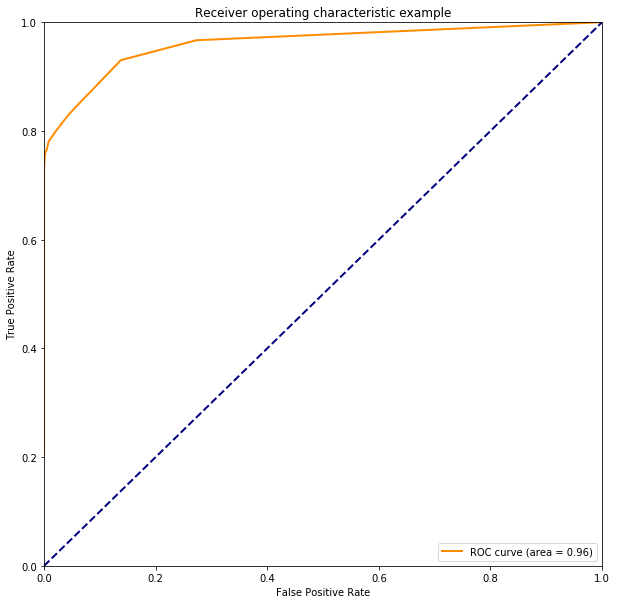

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
predicted_prob = modelxt.predict_proba(X_test_val)
# TASK: Rita ROC curve
# confidence_nb = predicted_prob.max(axis=1)
fpr, tpr, thresholds = roc_curve(Y_test_val, predicted_prob[:, 1])
roc_auc_nb = roc_auc_score(Y_test_val, predicted_prob[:, 1])
print("AUC:" + str(roc_auc_nb))

plt.figure(figsize=(10,10))
plt.title('Receiver operating characteristic example')
plt.plot(fpr, tpr, color='darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Precision and recall
High recall means that we manage to pick most of the positive examples (churn)
Low precision means that we also pick a lot of false positive for the churn which
means that a high recall and a low precision catches most of the true churn at the
cost of getting many false churn at the same time. Low precision = not so precise

See: https://medium.com/@klintcho/explaining-precision-and-recall-c770eb9c69e9 for a good explanation.

The chart below calculates the precision and recall for the different thresholds of the probability of our predicions.

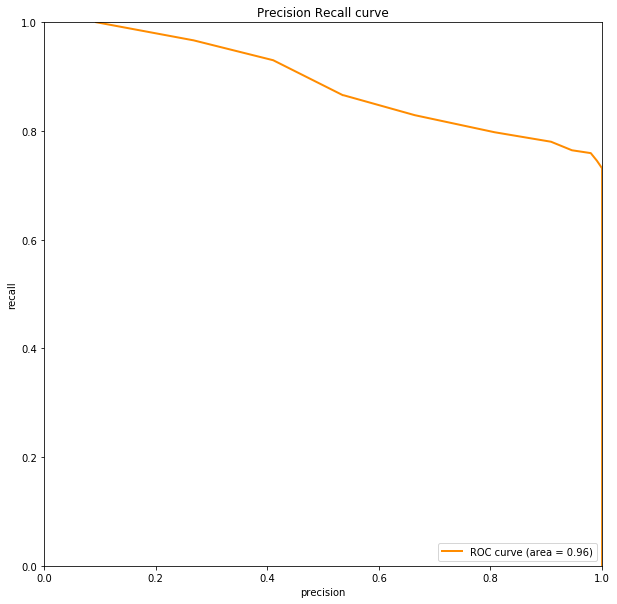

Precision:
[ 0.09330728  0.26673086  0.26698795  0.26711668  0.41        0.41031563
  0.53563715  0.53679654  0.66433566  0.80742049  0.90853659  0.94600432
  0.97972973  0.99071926  1.          1.          1.          1.          1.
  1.          1.          1.          1.        ]
Recall:
[ 1.          0.96684119  0.96684119  0.96684119  0.93019197  0.93019197
  0.86561955  0.86561955  0.82897033  0.79755672  0.78010471  0.76439791
  0.7591623   0.7452007   0.73123909  0.69808028  0.64048866  0.55671902
  0.40837696  0.40663176  0.20767888  0.20593368  0.        ]

If we want to catch every churn the precision would be only 9.33%
I.e. we would catch a huge number of false positive at the same time.
The other way around. If we want only True positive churn (no false) we would get a recall of X? %


In [19]:
precision, recall, thresholds_pr = precision_recall_curve(Y_test_val, predicted_prob[:,1])
plt.figure(figsize=(10,10))
plt.title('Precision Recall curve')
plt.plot(precision, recall, color='darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('precision')
plt.ylabel('recall')
plt.show()
print("Precision:\n" + str(precision))
print("Recall:\n" + str(recall))

print("\nIf we want to catch every churn the precision would be only " + "{:.2%}".format(precision[0]))
print("I.e. we would catch a huge number of false positive at the same time.")
print("The other way around. If we want only True positive churn (no false) we would get a recall of X? %")
# print("The other way around. If we want only True positive churn (no false) we would get a recall of " + "{:.2%}".format(recall[5]))

